# Further Analysis into the Ban of product imports in Ethiopia

## Objectives of this analysis

Upon looking at different articles and posts on the new mandate that bans different products from being imported, I was interested to delve deeper. Specifically, I wanted to answer one question. I wanted to know if the import value proportion of banned items of 6% is high or insignificant. 

## Motivation

At first glance, it might seem that the reduction is meager considering that we compared it with the total import value. In my opinion, this approach is a little misleading considering that only "38" products have been chosen out of about 4,700 products. Obviously, the number would be small given this information.

Rather, a more appropriate choice of comparison would be to look at all the different possible combinations of 4,700 products into "38" basket of import items. Then for each basket of import items, we compute the total import value proportion. This will give us a distribution of all the possible import reductions we can have by choosing "38" goods.
Now, if the average value of this distribution is very much greater than 6%, then we can say that we did not choose appropriate mix of items to maximize reduction of import value. If however, the average value of this distribution is very small compared to the 6%, then we can safely say that the choice of these products do actually bring about good reduction in import value.


## Analysis

In [185]:
# Import key libraries for analysis
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import math as m
import random
import warnings
warnings.filterwarnings('ignore')

In [186]:
# Get the data for analysis: If you are running this on your pc, make sure you change the 'path' file to the directory of the csv file you saved it. 
# If you do not want to change the code, make sure the directory of the csv file is the same path as this notebook.

path = 'Trade_Map_-_List_of_products_imported_by_Ethiopia_tarrif.xls.csv'
df = pd.read_csv(path)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7308 entries, 0 to 7307
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code                    7308 non-null   object 
 1   Product label           7308 non-null   object 
 2   Imported value in 2012  7308 non-null   int64  
 3   Imported value in 2013  7308 non-null   int64  
 4   Imported value in 2014  7308 non-null   int64  
 5   Imported value in 2015  7308 non-null   int64  
 6   Imported value in 2016  7308 non-null   int64  
 7   Imported value in 2017  7308 non-null   int64  
 8   Imported value in 2018  7308 non-null   int64  
 9   Imported value in 2019  7308 non-null   int64  
 10  Imported value in 2020  4784 non-null   float64
 11  Imported value in 2021  4767 non-null   float64
dtypes: float64(2), int64(8), object(2)
memory usage: 685.2+ KB
None


,Code,Product label,Imported value in 2012,Imported value in 2013,Imported value in 2014,Imported value in 2015,Imported value in 2016,Imported value in 2017,Imported value in 2018,Imported value in 2019,Imported value in 2020,Imported value in 2021
0,'15119010,"Palm oil and its fractions, whether or not ref...",382180,355204,403198,419168,438940,430341,459228,235729,340867.0,671217.0
1,'10011900,Durum wheat (excluding seed for sowing),0,0,127401,130624,300162,168075,184199,143344,146348.0,591537.0
2,'10063000,"Semi-milled or wholly milled rice, whether or ...",58351,64180,77815,114055,123866,126402,172683,113662,243654.0,560420.0
3,'27101990,"Medium oils and preparations, of petroleum or ...",2162873,996125,2148463,1235745,1095615,859348,721430,1464729,1270124.0,528764.0
4,'15121910,Sunflower-seed or safflower oil and their frac...,2427,4055,4309,15571,17854,53228,66858,123453,357569.0,376893.0


In [293]:
# Unpivot the dataset: To make the data structure normalized

#First Change columns to an integer with integer value for the year.

df.columns = ["Code","Product label"] + [int(x[len(x)-4:]) for x in df.columns[2:]]

TypeError: object of type 'int' has no len()

In [29]:
# Unpivot columns to have a data set with columns = [Code, Product label, year, value]

df_nw = pd.melt(df, id_vars = ["Code", "Product label"], value_vars = df.columns[2:], value_name = "Value", var_name = "Year")

# Remove all missing values from the analysis
df_a = df_nw.dropna()
df_a["Code"] = df_a["Code"].apply(lambda x: x[1:].strip())
print(df_a.info())
df_a.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68015 entries, 0 to 70538
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Code           68015 non-null  object 
 1   Product label  68015 non-null  object 
 2   Year           68015 non-null  object 
 3   Value          68015 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.6+ MB
None


,Code,Product label,Year,Value
0,15119010,"Palm oil and its fractions, whether or not ref...",2012,382180.0
1,10011900,Durum wheat (excluding seed for sowing),2012,0.0
2,10063000,"Semi-milled or wholly milled rice, whether or ...",2012,58351.0
3,27101990,"Medium oils and preparations, of petroleum or ...",2012,2162873.0
4,15121910,Sunflower-seed or safflower oil and their frac...,2012,2427.0


#### We will now filter the dataset to see which items are banned. 

Even though at first glance, it might appear that there are '38' products which are banned, a closer look at the table of banned items from the ministry of finance letter shows that each row has different levels of HS codes. In other words, some HS codes are written as higher level codes such as `"chapter 57"` for example, while others are written down as lower-level HS codes like `"49119190"`. Higher Level HS codes have 2 digits, and these items can be further classified into more specific categories with 4 digits which follow this pattern until there are 8 digits. As such, `"Chapter 57"` contains more than one product while `"49119190"` is a more specific product. So, saying that there are "38" products for analysis purposes is technically misleading but I do not see a problem when canonically used.

Therefore, it is best to first define the level of products first and then say how many products are actually banned. That is why I have been using the number "38" in quotation marks the whole time:) 

For this analysis, I will thus define the level of HS codes to 8 digits and start to define how many products are banned in that scope and filter the dataset to get the number of items in a basket of goods (n_banned).

In [138]:
# List of banned Items.
ban_items = ["1704","1806","1905","2009","2202100","22","2402","2403","2404"
             ,"3303","33041000","33042000","33043000","3401","3604","4202",
             "4909","4910","49119190","6504","6505","6702","6704","71","8703"
             ,"8711","8712","9401","9403","2501","95","91","6601","6602","57"
             ,"1601","1602","1604","19","21","6911"
             ,"6914","9613","9615","96180000","7013"]
# Add exceptions list
# For items in the letter termed "except electric motor vehicles", it is assumed that only vehicles with electric motors are allowed, 
#if the ban does not include vehicles with both electric motors and IC engines, then you can add the HS codes in the exceptions list.
exceptions = ["18062010", "711810","870240","870380","190110"] 




In [264]:
# Extract data for year 2021
da = df_a[df_a["Year"]==2021]

# Label each item as either "Banned" or "Not Banned" based on the ban_items present in the letter
da["Ban_Label"] = da["Code"].apply(lambda x:"Banned" if (any([(i == x[:len(i)]) for i in ban_items]) & (all([(j != x[:len(j)]) for j in exceptions]))) else "Not banned")


da[da["Ban_Label"]=="Banned"].sort_values("Value").head(20)




,Code,Product label,Year,Value,Ban_Label
70502,71131900,"Articles of jewellery and parts thereof, of pr...",2021,0.0,Banned
70452,94038200,"Furniture of bamboo (excl. seats and medical, ...",2021,0.0,Banned
70453,94015200,Seats of bamboo,2021,0.0,Banned
70501,71131190,"Articles of jewellery and parts thereof, of si...",2021,0.0,Banned
70497,22019000,"Ordinary natural water, not containing added s...",2021,0.0,Banned
70496,22011000,"Mineral waters and aerated waters, not contain...",2021,0.0,Banned
70500,71131110,"Articles of jewellery and parts thereof, of si...",2021,0.0,Banned
70451,95072000,"Fish-hooks, whether or not snelled",2021,1.0,Banned
70266,57021000,"Kelem, schumacks, karamanie and similar hand-w...",2021,1.0,Banned
70274,42029910,"Travelling-bags, shopping or tool bags, jewell...",2021,1.0,Banned


In [265]:
# Do some check if indeed we get a similar results that 6% of imports are banned.

Total_Sum = da["Value"].sum()
print("Total import value in thousands USD: ", f'{Total_Sum:,}')

print("by percentage: ", (da.groupby("Ban_Label")["Value"].sum()/Total_Sum).map('{:.1%}'.format))


print("by value in thousands USD: ", (da.groupby("Ban_Label")["Value"].sum()).map('{:,}'.format))

Total import value in thousands USD:  15,139,469.0
by percentage:  Ban_Label
Banned         6.7%
Not banned    93.3%
Name: Value, dtype: object
by value in thousands USD:  Ban_Label
Banned         1,017,806.0
Not banned    14,121,663.0
Name: Value, dtype: object


So, everything seems to be in check. We can go to the next steps.

In [266]:
# So now we count the number of banned items in the list.
n_all = da.groupby("Ban_Label")["Ban_Label"].count()
print(n_all)
n_banned = n_all["Banned"]

Ban_Label
Banned         461
Not banned    4306
Name: Ban_Label, dtype: int64


So, there are infact **461** specific (products with 8 digit HS codes) that are banned out of the 4700 products. 

In [294]:
# Now, we need to answer the question, how many combinations could we get if we grouped all the import products into 461 baskets of goods.
# To do that, we first need the length of unique HS codes in the dataset. 

HS = da["Code"].unique()
len_HS = len(HS)
print("Total Product types imported in the year: ", len_HS)

#However, considering that it would be unlikely that we would be banning "Priority" goods, we will only choose values that are not included in the priority list
# The list has been generated by looking the FXD/77/2021 directive. 
# Even though these priority items listed are for allocating foreign exchange currency, it is assumed that these products are a priority and would never be selected for banning.
# Plus, since no HS codes has been written in the directive, HS codes has been selected to best fit description of products.
# I would encourage the user of this file to change the values to include or exclude import items from the analysis.

#HS30 - pharmaceutical products
#HS12 - input for manufacturing edible oil
#HS2711 - Liquified Petroleum Gas
#HS27 - oil

#HS31- Fertilizers
#HS10 - cereals
#HS3808 - pesticides
#HS28 - raw materials and chemicals


#HS84212310 - motor oil
#HS3403 - lubricants
#HS84 - agricultural inputs and machineries
#HS90 - pharmaceutical product: laboratory and medical equipment
#HS190110 - import of nutritious food for babies
#HS4802 - exercise book, paper
#HS9608 - pens
#HS9609 - pencils




priority = ["30", "12","2711","27","31","10","3808","28","84212310","84","90","190110","4802","9608","9609"]

#Now we can remove priority items to get non-priority HS codes
non_priority_HS = [x for x in HS if (all([x[:len(i)] != i for i in priority]))]
len_non_priority_HS = len(non_priority_HS)
print("Total non-priority Product types imported in the year: ", len_non_priority_HS)

Total Product types imported in the year:  4767
Total non-priority Product types imported in the year:  3713


In [295]:
# Possible combinations
print("Total possible combinations of 4767 products to 468 specific items: ", m.comb(len_non_priority_HS,n_banned))

Total possible combinations of 4767 products to 468 specific items:  1610017969815160123157121694544886481051272917892217462604683555907628408867477383585299795569867975276871496835838681030058753226767564982940036047142050092079233137189723200530810345239469575232151043596692016518284946112883149643614167764384737732045003057342652578857016618859597521811186409983234994439045558443467818113369782901180967562073617693249462044945149245598127261708300242491267917226669835557749578285412957106640902658548428852309629419568396520933349733528127770132221419886983938469296330573697418368654966270927891124279686487126758451594269038754343648521074552211857495434553926272


This number is so large that I am not even going to attempt pronouncing that:) We can thus use random sampling techniques and take advantage of the central limit theorem to infer the mean value for this large set of population.

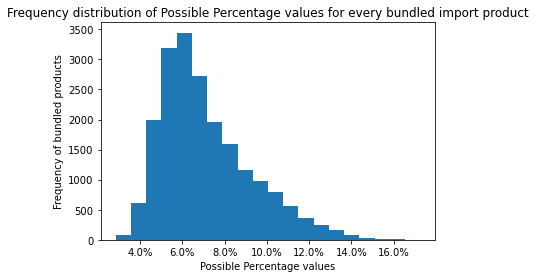

In [302]:
# Sample size: change the samples to your liking (the larger the sample, the better it approximates the population), however, it is best to limit the sample to avoid long computational times!

sample = 20000


# Create the basket for analysis
basket  = []
check = []
total_items = list(non_priority_HS)
while len(basket)!= sample:
    bundle = set(random.sample(total_items,n_banned))
    if bundle not in basket:
        basket.append(bundle)
    else:
        continue
        
# Calculate the total sum of all the values
Total_Sum = da["Value"].sum()

# Calculate the import values for each combination
Values = [(da[da["Code"].isin(basket[i])]["Value"].sum()/Total_Sum) for i in range(len(basket))]

# Graph

plt.hist(Values,bins = 20)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Possible Percentage values")
plt.ylabel("Frequency of bundled products")
plt.title("Frequency distribution of Possible Percentage values for every bundled import product");

In [297]:
# Save the values to send to other visualization softwares.
path = "final_result_nw.csv"
da_save = pd.DataFrame(data = Values, columns = ["Values"])
da_save.to_csv(path)

In [298]:
Average_value = sum(Values)/len(Values)
print("Average value for the distribution:", f'{Average_value:0.02%}')

Average value for the distribution: 7.13%


So, it appears that if we randomly choose a set of 461 items from a list of all the products, we might have better chances of producing better results than what is actually listed. Let us try this out.

In [299]:
# This following analysis is not technically scientific, but I am confident enough that if I randomly choose products, I might have better performance than the 6.7% one.
#random.seed(42) # As 42 is the secret of the universe :) remove 'random.seed(42)' if you want to see different results...
choose = random.sample(list(non_priority_HS),n_banned)
random_value = (da[da["Code"].isin(choose)]["Value"].sum()/Total_Sum)
print("percentage reduction from randomly choosing different products with the same quota of goods: ", f'{random_value:0.02%}')
da[da["Code"].isin(choose)].sort_values("Value")[["Code","Product label","Value"]].head(20)

percentage reduction from randomly choosing different products with the same quota of goods:  11.42%


,Code,Product label,Value
70537,52051100,"Single cotton yarn, of uncombed fibres, contai...",0.0
70466,07099300,"Fresh or chilled pumpkins, squash and gourds ""...",0.0
70481,02074500,Frozen cuts and edible offal of domestic ducks,0.0
70485,06031100,"Fresh cut roses and buds, of a kind suitable f...",0.0
70535,51119090,"Woven fabrics containing predominantly, but < ...",0.0
70502,71131900,"Articles of jewellery and parts thereof, of pr...",0.0
70513,66039090,"Parts, trimmings and accessories for umbrellas...",0.0
70501,71131190,"Articles of jewellery and parts thereof, of si...",0.0
70264,55093100,Single yarn containing >= 85% acrylic or modac...,1.0
70272,41079900,"Leather ""incl. parchment-dressed leather"" of t...",1.0


In [301]:
# Concretely, I am interested to know what the likelihood of getting import value of greater than the current performance of banned items.
cutoff = 0.067 # This is a cutoff percentage point where you want to check what the likelihood of getting a value greater than this point.
likelihood = sum([1 if i >=cutoff else 0 for i in Values])/len(Values)
print("Probability of getting better performance of",f'{cutoff:0.02%}',"is",f'{likelihood:0.02%}')

Probability of getting better performance of 6.70% is 48.39%


This shows that if we randomly pick import items to ban, we are about 48.39% more likely to have better performance than the already chosen items.

## Conclusion

There are two things I learned from this analysis. Firstly, given that they chose a lot of products to ban, it appears that the product mix is not optimized to reduce forex savings. If I have about 50% chance to reduce the forex savings by randomly choosing import items and still have better performance than the current forex reduction, then something must be done.

The second thing I learned, which is more personal, is that if we have the data or the information, it is best to be more curious and investigate the results yourself. For example, the "38 products" banned was something that everyone in the community has been saying. So, I thought that must be true. My prior analysis in fact assumed that there were 38 products that were banned and gave me a different story. However, when I looked at the letter, I do agree that there are 38 rows in the table of the letter, but within each row, there are more than one product being listed, some of them are a category of products, while others list very specific product type. To the broader community, I do not see the need to be very technical and be hung up on definitions like "what do we mean by products?" But, for analysis, these things are very important to talk about and we need to start discussing on those as well.
